In [678]:
from os.path import join as pjoin
import tqdm
import math
import pandas as pd
import numpy as np
import os
import torchvision
import time 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from PIL import Image
import torch.optim as optim
from sklearn.model_selection import train_test_split
import gc
import cv2
import torchmetrics
import matplotlib.pyplot as plt
from  torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall
from torchmetrics.classification import F1Score, Recall, Precision
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

In [679]:
label_map = {
             'abraham_grampa_simpson': 0,
             'agnes_skinner': 1,
             'apu_nahasapeemapetilon': 2,
             'barney_gumble': 3,
             'bart_simpson': 4,
             'carl_carlson': 5,
             'charles_montgomery_burns': 6,
             'chief_wiggum': 7,
             'cletus_spuckler': 8,
             'comic_book_guy': 9,
             'disco_stu': 10,
             'edna_krabappel': 11,
             'fat_tony': 12,
             'gil': 13,
             'groundskeeper_willie': 14,
             'homer_simpson': 15,
             'kent_brockman': 16,
             'krusty_the_clown': 17,
             'lenny_leonard': 18,
             'lionel_hutz': 19,
             'lisa_simpson': 20,
             'maggie_simpson': 21,
             'marge_simpson': 22,
             'martin_prince': 23,
             'mayor_quimby': 24,
             'milhouse_van_houten': 25,
             'miss_hoover': 26,
             'moe_szyslak': 27,
             'ned_flanders': 28,
             'nelson_muntz': 29,
             'otto_mann': 30,
             'patty_bouvier': 31,
             'principal_skinner': 32,
             'professor_john_frink': 33,
             'rainier_wolfcastle': 34,
             'ralph_wiggum': 35,
             'selma_bouvier': 36,
             'sideshow_bob': 37,
             'sideshow_mel': 38,
             'snake_jailbird': 39,
             'troy_mcclure': 40,
             'waylon_smithers': 41
             }

In [680]:
#Penalty
dict_num_for_img = {}
full_n = 0
folder = "/kaggle/input/simpson-norm/simpson/train"
for name, i in label_map.items():
    local_fold = Path(folder + "/" + name)
    sum_img = sum(1 for x in local_fold.iterdir())
    dict_num_for_img[name] = sum_img 
    full_n += sum_img

class_weight = []
for key, num in label_map.items():
    class_weight.append(full_n/dict_num_for_img[key])
print(torch.tensor(class_weight))
weights = []
alpha = 0.5 #0.5
beta = 1.0   #1.0
alpha1 = 0.000617073931658
beta1 = -0.00575310367963
for i in range(len(class_weight)):
    #w = alpha*(pow(math.log(class_weight[i]), beta))
    #w = (math.exp(alpha1*(class_weight[i] + beta1)))
    w = class_weight[i]
    weights.append(w)

#mormalize_weights = torch.tensor(list(normalized_weights), dtype=torch.float)
log_weights = torch.tensor(list(weights), dtype=torch.float)
weights = torch.tensor(list(class_weight), dtype=torch.float)

weights = log_weights
print(weights)

tensor([  22.9354,  498.5714,   33.6116,  197.5472,   15.6036,  213.6735,
          17.5524,   21.2373,  445.5319,   44.6482, 1903.6364,   45.8206,
         775.5555,  775.5555,  173.0578,    9.3232,   42.0482,   17.3632,
          67.5484, 2991.4285,   15.4653,  163.5938,   16.2200,  294.9296,
          85.1219,   19.4069, 1231.7646,   14.4215,   14.4017,   58.4916,
         654.3750,  290.8333,   17.5377,  322.1538,  465.3333,  235.2809,
         203.3010,   23.8769,  523.5000,  380.7273, 2617.5000,  115.6906])
tensor([  22.9354,  498.5714,   33.6116,  197.5472,   15.6036,  213.6735,
          17.5524,   21.2373,  445.5319,   44.6482, 1903.6364,   45.8206,
         775.5555,  775.5555,  173.0578,    9.3232,   42.0482,   17.3632,
          67.5484, 2991.4285,   15.4653,  163.5938,   16.2200,  294.9296,
          85.1219,   19.4069, 1231.7646,   14.4215,   14.4017,   58.4916,
         654.3750,  290.8333,   17.5377,  322.1538,  465.3333,  235.2809,
         203.3010,   23.8769,  523.50

In [681]:
#Learning model:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 100
batch_size = 128 #128
drop_p = 0.25 #0.25

#Optimizator
learning_rate = 0.00075 #0.00075
weight_decay_adam = 0.005  #0.005
gamma = 0.90
momentum = 0.9

#Loss
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight = weights)#, reduction='mean')

#Augmentation
mean = [0.44833415, 0.39369063, 0.33994608]#[0.40755875, 0.3577664,  0.30433772] 
std =  [0.22220887, 0.1992329 , 0.22570469]#[0.25371166, 0.22610066, 0.23893196] 

#Regularization
L2_enable = False
L1_enable = False
weight_decay = 0.001

#DownLoader
model_load = False
model_save = False

In [682]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 5),
    transforms.ColorJitter(brightness=0.001, contrast=0.001, saturation=0.001, hue=0.001),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)#[0.50435244, 0.45769847, 0.37291508], std=[0.24335187, 0.21073969, 0.23889251])
])

dataset_train = torchvision.datasets.ImageFolder(root='/kaggle/input/simpson-norm/simpson/train', transform=transform_train)
dataset_test  = torchvision.datasets.ImageFolder(root='/kaggle/input/simpson-norm/simpson/test' , transform=transform_test)

def compute_mean_and_std(dataset):
    mean = np.zeros(3)
    std = np.zeros(3)
    for img, _ in dataset:
        mean += np.mean(img.numpy(), axis=(1, 2))
        std += np.std(img.numpy(), axis=(1, 2))
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

num_train = len(dataset_train)
indices = list(range(num_train))

split = int(np.floor(0.8 * num_train))

np.random.seed(np.random.randint(0, 10000))
np.random.shuffle(indices)

train_idx, valid_idx = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

In [683]:
train_loader = torch.utils.data.DataLoader(dataset_train, sampler = train_sampler, batch_size=batch_size, 
                                         num_workers=0, drop_last=True)

valid_loader = torch.utils.data.DataLoader(dataset_train, sampler = valid_sampler, batch_size=batch_size, 
                                         num_workers=0, drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, 
                                         num_workers=0, drop_last=False)

print("Size of train dataset is", len(train_loader))
print("Size of valid dataset is", len(valid_loader))
print("Size of test dataset is", len(test_loader))

Size of train dataset is 130
Size of valid dataset is 32
Size of test dataset is 1


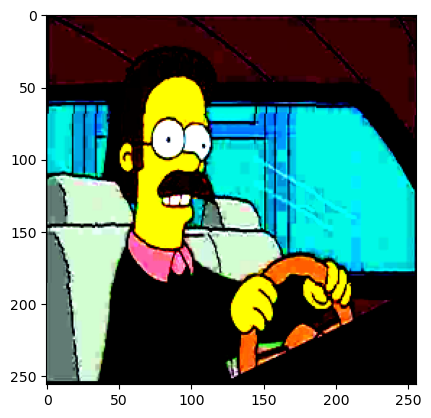

In [684]:
for batch_img, batch_label in train_loader:
    for j in range(batch_size):
        np_img = batch_img[j].numpy().transpose(1, 2, 0)
        plt.imshow(np_img)
        plt.show()
        break
    break

In [685]:
class SimpsonsCNN(nn.Module):
    def __init__(self):
        super(SimpsonsCNN, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d( 3, 32, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(32), nn.LeakyReLU())
        
        self.layer2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer3 = nn.Sequential(nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(32), nn.LeakyReLU(), 
                                    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(32), nn.LeakyReLU())
        
        self.layer4 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.layer5 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(64), nn.LeakyReLU())

        self.layer6 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.layer7 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), 
                                    nn.LeakyReLU(), nn.BatchNorm2d(64), 
                                    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(64), nn.LeakyReLU())
        
        self.layer8 = nn.MaxPool2d(kernel_size=2, stride=2)       
        
        self.layer9 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(128), nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer10 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(256), nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear( 2*16*128,1024)
        self.fc2 = nn.Linear(1024, 512)
        self.drop = nn.Dropout(drop_p)
        self.fc3 = nn.Linear( 512,  42)
        
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = x + self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x + self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        
        x = x.view(-1, 2*16*128)
        x = F.elu(self.drop(self.fc1(x)))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)

        return x

In [686]:
class GodNet(nn.Module):
    def __init__(self):
        super(GodNet, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d( 3, 32, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(32), nn.LeakyReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(64), nn.LeakyReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(128), nn.LeakyReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer_d3 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                                      nn.BatchNorm2d(64), nn.LeakyReLU())
        
        self.layer_d2 = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                                      nn.BatchNorm2d(32), nn.LeakyReLU())
        
        self.layer_d1 = nn.Sequential(nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                                      nn.BatchNorm2d(3), nn.LeakyReLU())
        
        self.layer_f1 = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1), 
                                    nn.BatchNorm2d(128), nn.LeakyReLU(),
                                    nn.AdaptiveAvgPool2d(output_size=(1,1)),
                                    nn.BatchNorm2d(128), nn.Dropout(drop_p), nn.LeakyReLU())
        
        self.fc = nn.Linear(128,  42)
        
    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x = x2 + self.layer_d3(x3)
        x = x1 + self.layer_d2(x)
        x = self.layer_d1(x)
        x = self.layer_f1(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [687]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def metrics(model, loader):
    classes = label_map
    classes_amount = len(label_map)
    recall = MulticlassRecall(num_classes=classes_amount, average=None)
    precision = MulticlassPrecision(num_classes=classes_amount, average=None)
    recall.to(device)
    precision.to(device)
    valid_acc = 0
    with torch.no_grad():
        my_loss = 0
        model.eval()
        correct = 0
        total = 0
        for sample in loader:
            images, labels = sample[0], sample[1]
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            recall.update(outputs, labels)
            precision.update(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            my_loss += criterion(outputs, labels).item()
        valid_acc = 100 * correct / total
        avr_loss = my_loss/len(loader)
    val_rec = sum(recall.compute())/len(list(label_map))
    val_prec = sum(precision.compute())/len(list(label_map))
    precision = val_prec.item()
    recall = val_rec.item()
    f1 = 2 * precision * recall / (precision + recall)
    return avr_loss, valid_acc, recall, precision, f1

def regularization(model):
    reg = 0
    if L2_enable:
            tens = (0.5 * weight_decay * sum(p.pow(2.0).sum() for p in model.parameters()))
            l2_reg = (tens.clone().detach().to(device))
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l2_reg = l2_reg + torch.norm(param)
            reg += weight_decay * l2_reg
        
    if L1_enable:
            tens = (0.5 * weight_decay * sum(p.abs().sum() for p in model.parameters()))
            l1_reg = (tens.clone().detach().to(device))
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l1_reg = l1_reg + torch.norm(param)
            reg += weight_decay * l1_reg
    return reg

In [688]:
model = SimpsonsCNN()
#model = GodNet()

In [689]:
model = model.to(device)
criterion = criterion.to(device)
print(count_parameters(model))

5223786


In [690]:
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay = weight_decay_adam)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)        
scaler = torch.cuda.amp.GradScaler()
torch.cuda.empty_cache()
gc.collect()
list_train_loss = []
list_valid_loss = []

In [691]:
if model_load:
    model.load_state_dict(torch.load('my_model.pt', map_location=device))

In [ ]:
print(f'-------------------------------------Learning begin, total of {num_epochs} epochs-----------------------------------\n')
for epoch in range(num_epochs):
    correct, total = 0, 0
    
    model.train()
    
    for i, sample in enumerate(train_loader):
        img, labels = sample[0], sample[1]
        img = img.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=True):
            output = model(img)
            loss = criterion(output, labels)
            _, pred = torch.max(output.data, 1)
        
        loss += regularization(model)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        
        if (i + 1) % 20 == 0:
            train_acc = 100 * correct / total
            correct, total = 0, 0
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], ', end = '')
            print(f'Loss: {loss.item():.4f}, Acc: {train_acc:.2f}%')
            list_train_loss.append(loss.item())
        torch.cuda.empty_cache()
        gc.collect()
        
    model.eval()
    avr_loss, val_acc, val_rec, val_prec, val_f1 = metrics(model, valid_loader)
    list_valid_loss.append(avr_loss)
    print(f'\n--------------------------------------------Result of Epoch {epoch}-------------------------------------------')
    print(f'Valid_Loss: {avr_loss:.4f}, Valid_accuracy: {val_acc:.2f}%, Valid Recall: {100*val_rec:.2f}%, ', end = '')
    print(f'Valid Precision: {100*val_prec:.2f}%, Valid F1: {100*val_f1:.2f}%')
    print(f'---------------------------------------------------------------------------------------------------------\n')
    avr_loss, test_acc, test_rec, test_prec, test_f1 = metrics(model, test_loader)
    print(f'\n--------------------------------------------Result of Testing-------------------------------------------')
    print(f'Test_Loss: {avr_loss:.4f}, Test_accuracy: {test_acc:.2f}%, Test Recall: {100*test_rec:.2f}%, ', end = '')
    print(f'Test Precision: {100*test_prec:.2f}%, Test F1: {100*test_f1:.2f}%')
    print(f'---------------------------------------------------------------------------------------------------------\n')
    if test_acc > 90:
        break
        
    if epoch % 2 == 1:    
        scheduler.step()

-------------------------------------Learning begin, total of 100 epochs-----------------------------------

Epoch [1/100], Step [20/130], Loss: 4.0626, Acc: 0.98%
Epoch [1/100], Step [40/130], Loss: 3.9258, Acc: 2.42%
Epoch [1/100], Step [60/130], Loss: 3.7544, Acc: 4.02%
Epoch [1/100], Step [80/130], Loss: 3.4068, Acc: 4.57%
Epoch [1/100], Step [100/130], Loss: 3.2417, Acc: 6.64%
Epoch [1/100], Step [120/130], Loss: 3.5872, Acc: 7.97%

--------------------------------------------Result of Epoch 0-------------------------------------------
Valid_Loss: 3.5534, Valid_accuracy: 11.06%, Valid Recall: 8.23%, Valid Precision: 8.07%, Valid F1: 8.15%
---------------------------------------------------------------------------------------------------------


--------------------------------------------Result of Testing-------------------------------------------
Test_Loss: 4.1440, Test_accuracy: 7.20%, Test Recall: 6.75%, Test Precision: 6.92%, Test F1: 6.83%
------------------------------------

In [ ]:
print(f'-------------------------------------------Learning complete------------------------------------------\n')
avr_loss, test_acc, test_rec, test_prec, test_f1 = metrics(model, test_loader)
print(f'\n--------------------------------------------Result of Testing-------------------------------------------')
print(f'Test_Loss: {avr_loss:.4f}, Test_accuracy: {test_acc:.2f}%, Test Recall: {100*test_rec:.2f}%, ', end = '')
print(f'Test Precision: {100*test_prec:.2f}%, Test F1: {100*test_f1:.2f}%')
print(f'---------------------------------------------------------------------------------------------------------\n')

In [ ]:
weights = []
for name, param in model.named_parameters():
    if 'weight' in name:
        weights += param.data.cpu().numpy().flatten().tolist()

weights = np.array(weights)

# Построение гистограммы
plt.hist(weights, bins=80, range = (-0.02, 0.02))
plt.xlabel('Weight values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
if model_save:
    torch.save(model.state_dict(), 'my_model1.pt')

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(list_train_loss, label='train')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(list_valid_loss, label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
loader = test_loader
classes = label_map
classes_amount = len(label_map)
recall = MulticlassRecall(num_classes=classes_amount, average=None)
precision = MulticlassPrecision(num_classes=classes_amount, average=None)
recall.to(device)
precision.to(device)
valid_acc = 0
with torch.no_grad():
        my_loss = 0
        model.eval()
        correct = 0
        total = 0
        for sample in loader:
            images, labels = sample[0], sample[1]
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            recall.update(outputs, labels)
            precision.update(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            my_loss += criterion(outputs, labels).item()
        valid_acc = 100 * correct / total
        avr_loss = my_loss/len(loader)
        
recall_class = {classname: val.item()
                for classname, val in zip(label_map, recall.compute())}
precision_class = {classname: val.item()
                   for classname, val in zip(label_map,precision.compute())}
metrics_per_class = {
    "recall": recall_class, "precision": precision_class}

fig, axes = plt.subplots(1, 2, figsize=(25, 5))
for (metricName, mVal), ax in zip(metrics_per_class.items(), axes):
    plt.sca(ax)
    plt.bar(mVal.keys(), mVal.values())
    plt.ylabel(metricName)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.yticks(ticks=np.arange(0, 1.01, 0.05))
plt.show()

In [ ]:
#model = torchvision.models.resnet50(pretrained=True)
#for param in model.parameters():
#    param.requires_grad = False

#model.fc = nn.Sequential(
#    nn.Linear(1024, 128),
#    nn.ReLU(inplace=True),
#    nn.Linear(128, 42))

#import time 
#start = time.time()
#end = time.time()
#print(end - start)

In [ ]:
#mean, std = compute_mean_and_std(dataset_train)

In [ ]:
#for name, layer in model.named_children():
#    print(name, layer)

In [ ]:
#path_for_test = 'simpson/archive_test'
#names = []
#for dirs, folder, files in os.walk(path_for_test):
#     for img in files:
#         ind = '_'.join(os.path.splitext(os.path.basename(path_for_test + '/' + img))[0].split('_')[:-1])
#         names.append(ind)
#names = list(set(names))
#print(len(names))
#folder_path = 'simpson'
#os.mkdir(folder_path+'/test')
#folder_path = folder_path + '/test'
#for folder in names:
#     if not os.path.exists(folder_path + '/' + folder):
#         os.mkdir(folder_path + '/' + folder)
#list_of_names = os.listdir(folder_path)
#print(list_of_names)
#for dirs, folder, files in os.walk(path_for_test):
#     for img in files:
#         ind = '_'.join(os.path.splitext(os.path.basename(path_for_test + '/' + img))[0].split('_')[:-1])
#         for name in list_of_names:
#             if ind == name:
#                 shutil.move(path_for_test + '/' + img, folder_path + '/' + name)

In [ ]:
#n_classes = 42
#class_counts = [0] * n_classes
#for _, target in train_loader.dataset:
#    class_counts[target] += 1
#n_samples = len(train_loader.dataset)
#weights = torch.tensor([n_samples / (n_classes * class_counts[i]) for i in range(n_classes)], dtype=torch.float)



In [ ]:
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
#if False:
#    for param in optimizer.state.values():
#        if isinstance(param, torch.Tensor):
#            param.to(device)
#        
#    for param in scheduler.state_dict():
#        if isinstance(scheduler.state_dict()[param], torch.Tensor):
#            scheduler.state_dict()[param] = scheduler.state_dict()[param].to(device)
#scheduler.step()

In [ ]:
(q(w) - x) * q(w) * (1 - q(w)) = 0

In [ ]:
(q(w) - x)^2 -> 0